## NOTEBOOK IMPORTS AND DATA

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [2]:
data = np.load('./models/Data-50-Components-y-XMean.npz')
data.files

['arr_0', 'arr_1', 'arr_2']

In [3]:
X = data['arr_0']
y = data['arr_1']
XMean = data['arr_2']

In [5]:
print(f'X Shape: {X.shape}')
print(f'y Shape: {y.shape}')
print(f'X Mean: {XMean}')

X Shape: (2303, 50)
y Shape: (2303,)
X Mean: 0.47799927221952515


## TRAIN TEST SPLIT

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=47)

print('Size of each spilt\n')
print(f'X Train: {X_train.shape}')
print(f'y Train: {y_train.shape}')
print()
print(f'X Test : {X_test.shape}')
print(f'y Test : {y_test.shape}')

Size of each spilt

X Train: (1842, 50)
y Train: (1842,)

X Test : (461, 50)
y Test : (461,)


## TRAINING SVC MODEL

In [9]:
model = SVC(gamma=0.01, random_state=47, probability=True)
model.fit(X_train, y_train)

SVC(gamma=0.01, probability=True, random_state=47)

In [10]:
print(f'Train Score : {model.score(X_train, y_train)}')
print(f'Test Score : {model.score(X_test, y_test)}')

Train Score : 0.8615635179153095
Test Score : 0.7982646420824295


## MODEL EVALUATION

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, cohen_kappa_score, auc

In [13]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

#### CONFUSION MATRIX

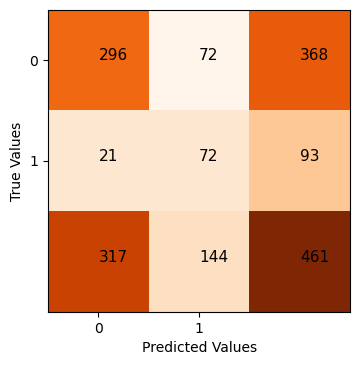

In [14]:
cm = confusion_matrix(y_test, y_pred)

cm = np.concatenate((cm, cm.sum(axis=0).reshape(1, -1)), axis=0)
cm = np.concatenate((cm, cm.sum(axis=1).reshape(-1, 1)), axis=1)

plt.figure(dpi=100)
plt.imshow(cm, cmap='Oranges')

for i in range(3):
    for j in range(3):
        plt.text(i, j, cm[i, j], fontdict={'fontsize':11})
        
plt.xticks([0, 1])
plt.yticks([0, 1])

plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

#### CALSSIFICATION REPORT

In [15]:
print(classification_report(y_test, y_pred, 
                            target_names=['male', 'female'], 
                            output_dict=False))

              precision    recall  f1-score   support

        male       0.80      0.93      0.86       317
      female       0.77      0.50      0.61       144

    accuracy                           0.80       461
   macro avg       0.79      0.72      0.74       461
weighted avg       0.79      0.80      0.78       461



In [16]:
report = classification_report(y_test, y_pred, 
                            target_names=['male', 'female'], 
                            output_dict=True)
report = pd.DataFrame(report).T
report

,precision,recall,f1-score,support
male,0.804348,0.933754,0.864234,317.000000
female,0.774194,0.500000,0.607595,144.000000
accuracy,0.798265,0.798265,0.798265,0.798265
macro avg,0.789271,0.716877,0.735914,461.000000
weighted avg,0.794929,0.798265,0.784069,461.000000


#### KAPPA SCORE

In [18]:
kappa = cohen_kappa_score(y_test, y_pred)
kappa

0.4801571423374923

    For a good model the kappa score must be greater than 60%
    if kappa score is less than 40% it is a bad model
    and if kappa score is less than 20% its a worst model, dont consider it

#### ROC AUC

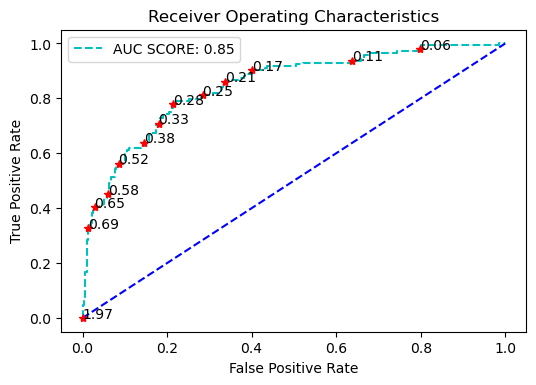

In [19]:
# for female
fpr, tpr, thresh = roc_curve(y_test, y_prob[:, 1])

auc_score = auc(fpr, tpr)

plt.figure(dpi=100)

plt.plot(fpr, tpr, 'c--')
plt.plot([0, 1], [0, 1], 'b--')

for i in range(0, len(thresh), 10):
    plt.plot(fpr[i], tpr[i], 'r*')
    plt.text(fpr[i], tpr[i], "%0.2f"%thresh[i])
    
plt.legend(['AUC SCORE: %0.2f'%auc_score])
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')

plt.show()

## HYPERPARAMETER TUNING

In [28]:
from sklearn.model_selection import GridSearchCV
import time

In [29]:
model_tune = SVC()

param_grid = {
    'C': [1, 10, 20, 30, 50, 100],
    'kernel': ['rbf', 'poly'],
    'gamma': [0.1, 0.05, 0.01, 0.001, 0.002, 0.005],
    'coef0': [0, 1]
}

In [30]:
%%time
grid = GridSearchCV(estimator=model_tune,
                    param_grid=param_grid,
                    scoring='accuracy', 
                    cv=5, verbose=1, n_jobs=-1)

grid.fit(X, y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.1min finished


Wall time: 2min 3s


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 20, 30, 50, 100], 'coef0': [0, 1],
                         'gamma': [0.1, 0.05, 0.01, 0.001, 0.002, 0.005],
                         'kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [31]:
grid.best_score_

0.8154522305008017

#### BEST MODEL

In [32]:
best_model = SVC(C=grid.best_params_['C'],
                coef0=grid.best_params_['coef0'],
                gamma=grid.best_params_['gamma'],
                kernel=grid.best_params_['kernel'], probability=True)

best_model.fit(X_train, y_train)

print(best_model.score(X_train, y_train))
print(best_model.score(X_test, y_test))

0.9180238870792616
0.824295010845987


In [34]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

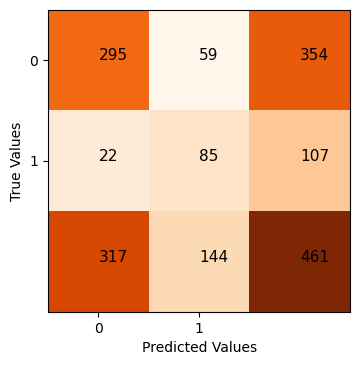

In [35]:
cm = confusion_matrix(y_test, y_pred)

cm = np.concatenate((cm, cm.sum(axis=0).reshape(1, -1)), axis=0)
cm = np.concatenate((cm, cm.sum(axis=1).reshape(-1, 1)), axis=1)

plt.figure(dpi=100)
plt.imshow(cm, cmap='Oranges')

for i in range(3):
    for j in range(3):
        plt.text(i, j, cm[i, j], fontdict={'fontsize':11})
        
plt.xticks([0, 1])
plt.yticks([0, 1])

plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

In [36]:
report = classification_report(y_test, y_pred, 
                            target_names=['male', 'female'], 
                            output_dict=True)
report = pd.DataFrame(report).T
report

,precision,recall,f1-score,support
male,0.833333,0.930599,0.879285,317.000000
female,0.794393,0.590278,0.677291,144.000000
accuracy,0.824295,0.824295,0.824295,0.824295
macro avg,0.813863,0.760439,0.778288,461.000000
weighted avg,0.821170,0.824295,0.816189,461.000000


In [37]:
kappa = cohen_kappa_score(y_test, y_pred)
kappa

0.5601507744861299

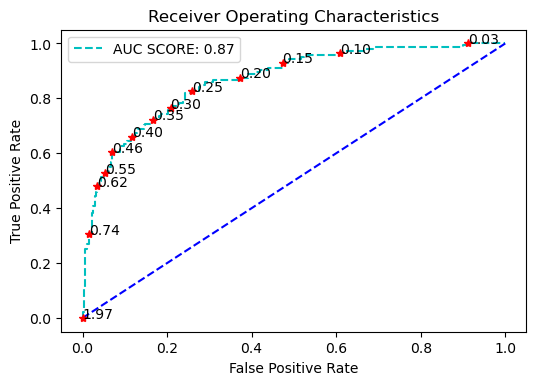

In [38]:
# for female
fpr, tpr, thresh = roc_curve(y_test, y_prob[:, 1])

auc_score = auc(fpr, tpr)

plt.figure(dpi=100)

plt.plot(fpr, tpr, 'c--')
plt.plot([0, 1], [0, 1], 'b--')

for i in range(0, len(thresh), 10):
    plt.plot(fpr[i], tpr[i], 'r*')
    plt.text(fpr[i], tpr[i], "%0.2f"%thresh[i])
    
plt.legend(['AUC SCORE: %0.2f'%auc_score])
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')

plt.show()

## SAVING THE MODEL

In [39]:
import pickle

pickle.dump(best_model, open('./models/SVC_Model.pickle', 'wb'))
pickle.dump(XMean, open('./models/XMean.pickle', 'wb'))